In [1]:
import pennylane as qml
import pennylane.numpy as np
import jax.numpy as jnp

import jax
import optax

from time import time
import pickle

import matplotlib.pyplot as plt

import os, sys

parent = os.path.abspath('../src')
sys.path.insert(1, parent)

from perceptron import NativePerceptron
from perceptron import Perceptron

# Set to float64 precision and remove jax CPU/GPU warning
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")


# Setting up the Problem

In [9]:
# setting up the problem
perceptron_qubits = 2
pulse_basis = 16
ts = jnp.array([1.0])
t = 1

dev = qml.device("default.qubit.jax", wires = perceptron_qubits)


perceptron =NativePerceptron(perceptron_qubits, pulse_basis, basis='gaussian', pulse_width=0.005, native_coupling=1)

H =  perceptron.H

H_obj, H_obj_spectrum = perceptron.get_1d_ising_hamiltonian(0.1)

# e_ground_state_exact = H_obj_spectrum[0]

print(f'Ising Model Hamiltonian:\nH = {H_obj}')
# print(f'Exact ground state energy: {e_ground_state_exact}')


Ising Model Hamiltonian:
H =   (0.1) [X0]
+ (0.1) [X1]
+ (1.0) [Z0 Z1]


/Users/jorgegarciaponce/Research/Yelin/PerceptronLossLandscapes/.venv/lib/python3.11/site-packages/pennylane/ops/functions/eigvals.py:108: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires. Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


In [10]:
perceptron.H

  (1*(PauliZ(wires=[0]) @ PauliZ(wires=[1])))
+ (gaussian_field(params_0, t)*(PauliX(wires=[0])))
+ (gaussian_field(params_1, t)*(PauliX(wires=[1])))
+ (gaussian_field(params_2, t)*(PauliY(wires=[0])))
+ (gaussian_field(params_3, t)*(PauliY(wires=[1])))

In [11]:
V = qml.matrix(qml.evolve(H_obj, 1))

# @jax.jit
def loss(param_vector):

    param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

    U = qml.matrix(qml.evolve(perceptron.H)(param_list, t))

    return qml.math.frobenius_inner_product(jnp.conjugate(U-V),U-V).real


In [12]:
perceptron.get_random_parameter_vector(78680)

Array([0.25703401, 0.95794489, 0.9315451 , 0.21982997, 0.07989672,
       0.82378447, 0.76845911, 0.32975037, 0.0411121 , 0.7507967 ,
       0.60668798, 0.73351756, 0.34244384, 0.59320246, 0.51619732,
       0.75986847, 0.84199611, 0.4007286 , 0.41215723, 0.05479216,
       0.56435878, 0.59173568, 0.7195821 , 0.55783444, 0.2715738 ,
       0.4786959 , 0.52160384, 0.61177807, 0.1059213 , 0.37146242,
       0.06849853, 0.38757868, 0.23232501, 0.52642851, 0.65688201,
       0.19662277, 0.89526878, 0.75692948, 0.08215422, 0.70341644,
       0.88259295, 0.2494096 , 0.66876747, 0.784708  , 0.15063363,
       0.22730058, 0.30901653, 0.02827656, 0.42743921, 0.5570453 ,
       0.29298136, 0.9216619 , 0.83361192, 0.5275031 , 0.68302377,
       0.03450286, 0.49935783, 0.02396676, 0.93657703, 0.63879929,
       0.0238281 , 0.5335222 , 0.81474135, 0.31680277], dtype=float64)

In [13]:
# getting the loss_function
# loss = get_loss_function(perceptron, ts, H_obj, dev)

param_vector = perceptron.get_random_parameter_vector(534)

print(f'Initial parameters: {param_vector}')

print(f'Initial loss: {loss(param_vector)}')

initial_gradients = jax.grad(loss)(param_vector)
print(f'Initial gradients: {initial_gradients}')

value_and_grad = jax.jit(jax.value_and_grad(loss))

Initial parameters: [0.95670975 0.04032361 0.2158257  0.40651092 0.23804491 0.1688695
 0.78627564 0.19620481 0.01584767 0.30083804 0.55352106 0.88662085
 0.64656065 0.53874292 0.23869466 0.86566923 0.85899796 0.61856846
 0.52810881 0.03861421 0.20344303 0.54574844 0.56922254 0.65358345
 0.75837486 0.68904677 0.15878322 0.5661503  0.48728277 0.73253196
 0.11685569 0.16035572 0.18640057 0.89023546 0.19818604 0.28175048
 0.23702829 0.03695089 0.03034612 0.67169672 0.62312258 0.85818086
 0.48541458 0.34295275 0.39635385 0.5880937  0.07533057 0.62962078
 0.3727403  0.88103618 0.13466577 0.49556816 0.36291251 0.3304237
 0.1701631  0.35879815 0.37440313 0.27305609 0.54336085 0.3866041
 0.16536833 0.01310816 0.09275623 0.01198754]
Initial loss: 8.765501455614734
Initial gradients: [ 0.52646023  0.51199573  0.47407269  0.96763853  2.13390203  2.76039843
  2.82795587  1.92499235 -1.52155641 -2.60374439  0.19078503  0.45367779
 -1.34245326 -0.61927536  1.21003525  1.74726706  0.51698382 -0.057172

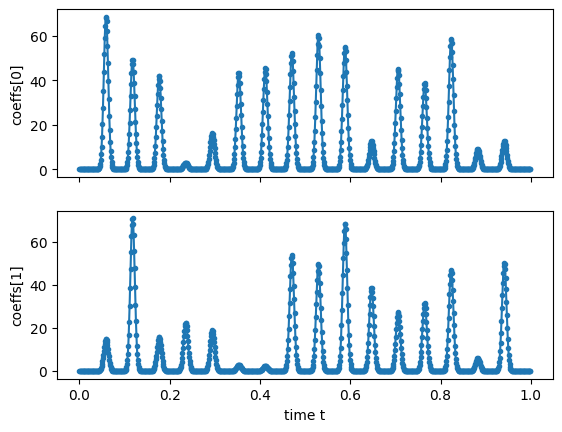

In [14]:
ts = jnp.linspace(0.0, 1, 1000)[:-1]

param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

fig, axs = plt.subplots(nrows=perceptron_qubits, sharex=True)
for i in range(perceptron_qubits):
    ax = axs[i]
    ax.plot(ts, perceptron.control_fields[i](param_list[i+perceptron_qubits-1], ts), ".-")
    ax.set_ylabel(f"coeffs[{i}]")
ax.set_xlabel("time t")
plt.show()

In [15]:
from datetime import datetime

n_epochs = 6000
param_vector = perceptron.get_random_parameter_vector(534)


# The following block creates a constant schedule of the learning rate
# that increases from 0.1 to 0.5 after 10 epochs
schedule0 = optax.constant_schedule(0.1)
schedule1 = optax.constant_schedule(0.01)
schedule2 = optax.constant_schedule(0.001)
schedule = optax.join_schedules([schedule0, schedule1, schedule2], [200, 3000])

optimizer = optax.adam(learning_rate=schedule)

# optimizer = optax.adam(learning_rate=0.5)
# optimizer = optax.adabelief(0.1)
opt_state = optimizer.init(param_vector)

energies = np.zeros(n_epochs )
# energy[0] = loss(param_vector)
mean_gradients = np.zeros(n_epochs)

gradients_trajectory = []
param_trajectory = []

# ## Compile the evaluation and gradient function and report compilation time
# time0 = time()
# _ = value_and_grad(param_vector)
# time1 = time()

# print(f"grad and val compilation time: {time1 - time0}")


## Optimization loop
for n in range(n_epochs):
    val, grads = value_and_grad(param_vector)
    updates, opt_state = optimizer.update(grads, opt_state)

    mean_gradients[n] = np.mean(np.abs(grads))
    energies[n] = val
    param_trajectory.append(param_vector)
    gradients_trajectory.append(grads)

    param_vector = optax.apply_updates(param_vector, updates)

    if not n % 10:
        print(f"{n+1} / {n_epochs}; Frobenius norm: {val}")
        print(f"    mean grad: {mean_gradients[n]}")
        print(f'    gradient norm: {jnp.linalg.norm(grads)}')
        if n>=2:
            print(f'    difference of gradients: {jnp.linalg.norm(grads-gradients_trajectory[-2])}')



print(f"Optimal Frobenius Norm Found: {energies[-1]}")


1 / 6000; Frobenius norm: 8.765501455614734
    mean grad: 0.8018401331824503
    gradient norm: 9.469335788775817
11 / 6000; Frobenius norm: 2.653197892844417
    mean grad: 0.7191432121083927
    gradient norm: 7.400638841453292
    difference of gradients: 4.489821740438876
21 / 6000; Frobenius norm: 1.4500080946714031
    mean grad: 0.46270042259978406
    gradient norm: 4.941352299126244
    difference of gradients: 2.10423238261179
31 / 6000; Frobenius norm: 0.8120578085339883
    mean grad: 0.2956295180660469
    gradient norm: 2.9507902409651425
    difference of gradients: 1.8091493972191985
41 / 6000; Frobenius norm: 0.3953307581604271
    mean grad: 0.192296603137887
    gradient norm: 1.7283970481100512
    difference of gradients: 1.3223231252984695
51 / 6000; Frobenius norm: 0.20915933040895215
    mean grad: 0.04962677697601975
    gradient norm: 0.5152459195421456
    difference of gradients: 1.1136358242858158
61 / 6000; Frobenius norm: 0.1300695935111265
    mean grad

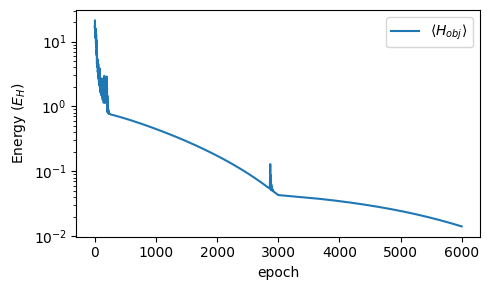

In [40]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

y = energies 
ax.plot(y, label="$\\langle H_{{obj}}\\rangle$")
# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle$")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
# ax.set_yscale("log")
ax.set_ylabel("Energy ($E_H$)")
ax.set_yscale("log")
ax.set_xlabel("epoch")
ax.legend()

plt.tight_layout()
plt.show()

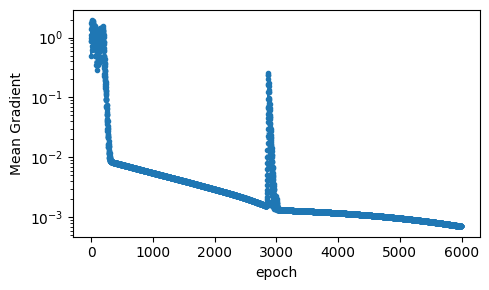

In [41]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = mean_gradients
# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, ".:")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
ax.set_yscale("log")
ax.set_ylabel("Mean Gradient")
ax.set_xlabel("epoch")
# ax.legend()

plt.tight_layout()
plt.show()

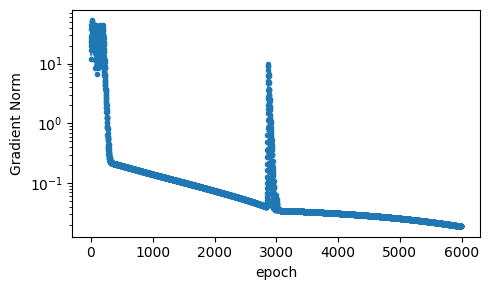

In [42]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = [jnp.linalg.norm(gradient) for gradient in gradients_trajectory]
# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, ".:")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
ax.set_yscale("log")
ax.set_ylabel("Gradient Norm")
ax.set_xlabel("epoch")
# ax.legend()

plt.tight_layout()
plt.show()

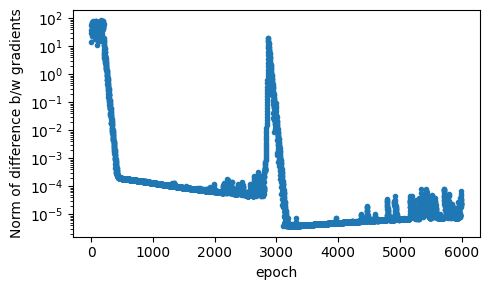

In [43]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = [jnp.linalg.norm(gradients_trajectory[j] - gradients_trajectory[j-1]) for j in range(1,len(gradients_trajectory))]
# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, ".:")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
ax.set_yscale("log")
ax.set_ylabel("Norm of difference b/w gradients")
ax.set_xlabel("epoch")
# ax.legend()

plt.tight_layout()
plt.show()

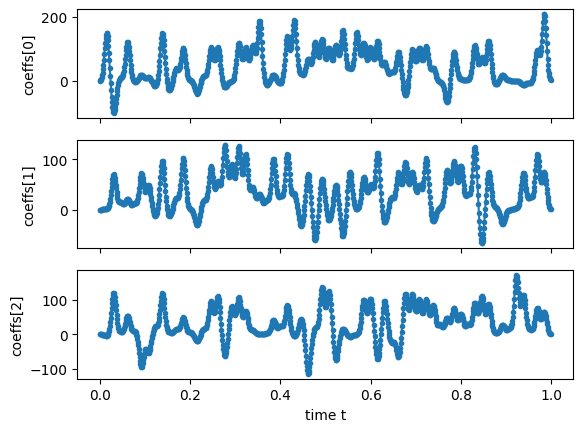

In [44]:
ts = jnp.linspace(0.0, 1, 1000)[:-1]

param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

fig, axs = plt.subplots(nrows=perceptron_qubits, sharex=True)
for i in range(perceptron_qubits):
    ax = axs[i]
    ax.plot(ts, perceptron.control_fields[i](param_list[i+perceptron_qubits-1], ts), ".-")
    ax.set_ylabel(f"coeffs[{i}]")
ax.set_xlabel("time t")
plt.show()

In [45]:
# Calculating the Final Hessian

final_hessian = jax.jacrev(jax.jacrev(loss))(param_vector)
final_hessian_eigenvalues = jnp.linalg.eigvals(final_hessian)
final_hessian_eigenvalues

Array([ 6.69923352e+02+0.j,  6.64073195e+02+0.j,  4.85823707e+02+0.j,
        5.29956541e+02+0.j,  5.58304531e+02+0.j,  5.42379155e+02+0.j,
        3.12588385e+02+0.j,  2.76425086e+02+0.j,  2.33935943e+02+0.j,
        1.13204777e+02+0.j,  1.04701474e+02+0.j,  7.30291460e+01+0.j,
        7.35879566e+01+0.j,  6.66394169e+01+0.j,  6.53782791e+01+0.j,
        1.09111985e+01+0.j,  7.41549028e+00+0.j,  1.55964634e+00+0.j,
        1.47658927e+00+0.j,  1.44126480e+00+0.j,  1.16669069e+00+0.j,
        1.12455193e+00+0.j,  9.26164259e-01+0.j,  7.29403429e-01+0.j,
        6.32099779e-01+0.j,  5.99552071e-01+0.j,  5.62519336e-01+0.j,
        5.19863729e-01+0.j,  4.43885031e-01+0.j,  3.96000650e-01+0.j,
        3.69507074e-01+0.j,  3.41805852e-01+0.j,  3.24156838e-01+0.j,
        2.81802274e-01+0.j,  2.72337211e-01+0.j,  2.55787933e-01+0.j,
        2.50597995e-01+0.j,  2.12407713e-01+0.j,  1.97000479e-01+0.j,
        1.79129709e-01+0.j,  1.66616233e-01+0.j,  1.64822080e-01+0.j,
        1.62455074e-

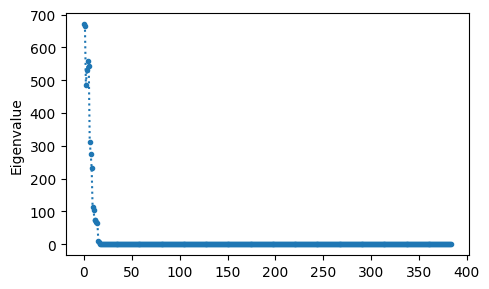

In [46]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = np.linalg.eigvals(final_hessian)

# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, ".:")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
# ax.set_yscale("log")
ax.set_ylabel("Eigenvalue")
# ax.set_xlabel("Eigenvalue")
# ax.legend()
y

plt.tight_layout()
plt.show()